# Поскольку многозадачное обучение себя не очень хорошо показало, мы в дерьме. <br>
## Есть несколько вариантов решения этой проблемы. <br>
1. Можно использовать egemaps как информацию, внедряемую на один из скрытых слоев нейронки. Обязательно протестирую этот вариант чуть позже, поскольку следующий вариант гораздо проще в реализации. 
2. В своих моделях я использовал одноканальное изображение. Есть следующая стратегия улучшения: делаем из одноканального изображения трехканальное: первый канал - спектрограмма, второй - первая производная, третий - вторая производная. Подход реализуемый за час времени, подход используемый (видел пару статей в которых это применялось, однако там была трехмерная свертка)

### Пробую поиграться со вторым подходом. <br>
Код модуля iemocap.py был изменен, в класс IemocapDataset был добавлен параметр channels=(grayscale | rgb | delta): <br>
grayscale: обычное одноканальное изображение, параметр по умолчанию <br>
rgb: трехканальное изображение, получаемое путем копирования одного канала в два других <br>
delta: в первом канале спектрограмма, во втором и третьем - первая и вторая производные 

In [8]:
from models.models_one_task import AlexNet, vgg
from datasets.iemocap import IemocapDataset
from datasets.ramas import RamasDataset
from constants import *
from torchsummary import summary
import torch
import torch.nn as nn
import skorch
from skorch.helper import predefined_split
from skorch.dataset import Dataset
from skorch.classifier import NeuralNetClassifier
import skorch.callbacks as callbacks
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import cv2

In [2]:
class UnNormalize(object):  # Этот класс нужен, чтобы адекватно отображать изображения в imshow()
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor
unnorm = UnNormalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

#### По умолчанию изображения одноканальные:

In [3]:
iemocap = IemocapDataset(  # Без препроцессинга, тренировочный, аугментация включена
    PATH_TO_PICKLE, IEMOCAP_PATH_TO_WAVS, IEMOCAP_PATH_TO_EGEMAPS, IEMOCAP_PATH_FOR_PARSER, 
    base_name='IEMOCAP-4', label_type='four', mode='train', preprocessing=False, 
    augmentation=True, padding='repeat', spectrogram_shape=224, spectrogram_type='melspec', tasks='emotion', 
    channels='grayscale'
)

============= INITIALIZING DATASET IEMOCAP-4_four_prep-false_224_train ===============
=========================== SUCCESS! ====================================


(1, 224, 224)


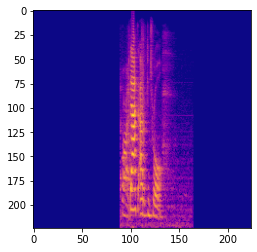

In [4]:
img, labels = iemocap[3]
img = unnorm(img)
img = img.numpy()
print(img.shape)
img = np.squeeze(img, axis=0)
imgplot = plt.imshow(img, cmap='plasma')

#### Пробуем отобразить трехканальное изображение:

============= INITIALIZING DATASET IEMOCAP-4_four_prep-false_224_train ===============
=========================== SUCCESS! ====================================
(224, 224, 3)


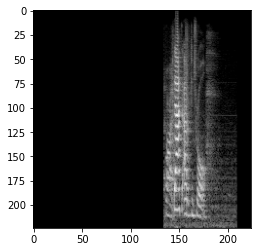

In [5]:
iemocap_rgb = IemocapDataset(  # Без препроцессинга, тренировочный, аугментация включена
    PATH_TO_PICKLE, IEMOCAP_PATH_TO_WAVS, IEMOCAP_PATH_TO_EGEMAPS, IEMOCAP_PATH_FOR_PARSER, 
    base_name='IEMOCAP-4', label_type='four', mode='train', preprocessing=False, 
    augmentation=True, padding='repeat', spectrogram_shape=224, spectrogram_type='melspec', tasks='emotion', 
    channels='rgb'
)
img, labels = iemocap_rgb[3]
img = unnorm(img)
img = img.permute(1, 2, 0)  # Для imshow() каналы должны быть в последнем измерении
img = img.numpy()
print(img.shape)
imgplot = plt.imshow(img)

#### Пробуем отобразить третий вариант

============= INITIALIZING DATASET IEMOCAP-4_four_prep-true_224_test ===============
=========================== SUCCESS! ====================================
(224, 224, 3)


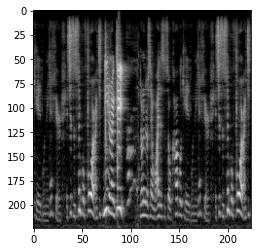

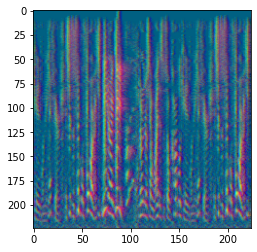

In [6]:
iemocap_rgb = IemocapDataset(  # Без препроцессинга, тренировочный, аугментация включена
    PATH_TO_PICKLE, IEMOCAP_PATH_TO_WAVS, IEMOCAP_PATH_TO_EGEMAPS, IEMOCAP_PATH_FOR_PARSER, 
    base_name='IEMOCAP-4', label_type='four', mode='test', preprocessing=True, 
    augmentation=True, padding='repeat', spectrogram_shape=224, spectrogram_type='melspec', tasks='emotion', 
    channels='rgb'
)
img, labels = iemocap_rgb[1]
img = unnorm(img)
img = img.permute(1, 2, 0)  # Для imshow() каналы должны быть в последнем измерении
img = img.numpy()
print(img.shape)
imgplot = plt.imshow(img)
plt.show()
iemocap_rgb.channels = 'delta'
img, labels = iemocap_rgb[1]
img = unnorm(img)
img = img.permute(1, 2, 0)  # Для imshow() каналы должны быть в последнем измерении
img = img.numpy()
imgplot = plt.imshow(img)
plt.show()

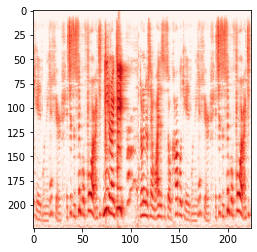

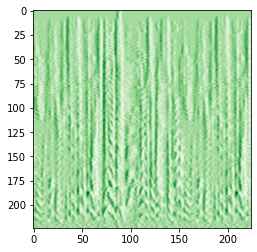

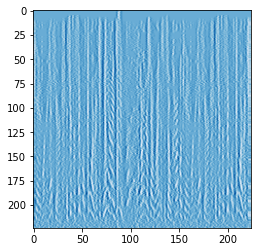

In [11]:
spec, delta, delta2 = cv2.split(img)
plt.imshow(spec, cmap='Reds')
plt.show()
plt.imshow(delta, cmap='Greens')
plt.show()
plt.imshow(delta2, cmap='Blues')
plt.show()

## Пробую обучить AlexNet и VGG-11 

### AlexNet

In [13]:
iemocap_224_noprep_train = IemocapDataset(  # Без препроцессинга, тренировочный
    PATH_TO_PICKLE, IEMOCAP_PATH_TO_WAVS, IEMOCAP_PATH_TO_EGEMAPS, IEMOCAP_PATH_FOR_PARSER, 
    base_name='IEMOCAP-4', label_type='four', mode='train', preprocessing=False, 
    augmentation=True, padding='repeat', spectrogram_shape=224, spectrogram_type='melspec', tasks='emotion', channels='delta'
)
iemocap_224_noprep_test = IemocapDataset(  # Без препроцессинга, тестовый
    PATH_TO_PICKLE, IEMOCAP_PATH_TO_WAVS, IEMOCAP_PATH_TO_EGEMAPS, IEMOCAP_PATH_FOR_PARSER, 
    base_name='IEMOCAP-4', label_type='four', mode='test', preprocessing=False, 
    augmentation=True, padding='repeat', spectrogram_shape=224, spectrogram_type='melspec', tasks='emotion', channels='delta'
)

============= INITIALIZING DATASET IEMOCAP-4_four_prep-false_224_train ===============
=========================== SUCCESS! ====================================
============= INITIALIZING DATASET IEMOCAP-4_four_prep-false_224_test ===============
=========================== SUCCESS! ====================================


In [14]:
train_dataset = iemocap_224_noprep_train
test_dataset = iemocap_224_noprep_test

In [15]:
filename = 'AlexNetDelta--{}_augmentation-{}.md'.format(train_dataset.name, str(train_dataset.augmentation).lower())
best_model_file_path = os.path.join(RESULTS_FOLDER, filename)
callback_train_acc = callbacks.EpochScoring(scoring="accuracy", 
                                            lower_is_better=False, 
                                            on_train=True, 
                                            name='train_acc')
callback_save_best = callbacks.Checkpoint(monitor='valid_loss_best', 
                                          f_params=None, 
                                          f_optimizer=None, 
                                          f_criterion=None, 
                                          f_history=None, 
                                          f_pickle=best_model_file_path,  
                                          event_name='event_cp')
callback_early_stop = callbacks.EarlyStopping(monitor='valid_loss', patience=30, 
                                              threshold_mode='rel', lower_is_better=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

In [16]:
model = AlexNet(num_classes=4)
net = skorch.classifier.NeuralNetClassifier(
    model, criterion=nn.CrossEntropyLoss, optimizer=torch.optim.Adam,
    lr=1e-5, max_epochs=300, batch_size=32, train_split=predefined_split(test_dataset), 
    device=device, iterator_train__shuffle=True, 
    callbacks=[
        callback_train_acc,
        callback_save_best,
        callback_early_stop
    ]
)

In [17]:
net.fit(train_dataset, None)

  epoch    train_acc    train_loss    valid_acc    valid_loss    cp      dur
-------  -----------  ------------  -----------  ------------  ----  -------
      1       0.3589        1.3499       0.3807        1.3215     +  56.3201
      2       0.3810        1.3267       0.3807        1.3215     +  54.7480
      3       0.3847        1.3149       0.4569        1.2750     +  53.4072
      4       0.4295        1.2709       0.4524        1.2354     +  59.7384
      5       0.4426        1.2391       0.4378        1.1932     +  59.8462
      6       0.4698        1.1844       0.5308        1.0897     +  60.5357
      7       0.5095        1.1232       0.5655        1.0201     +  61.5283
      8       0.5344        1.0971       0.5442        1.0234        55.6959
      9       0.5448        1.0733       0.5801        1.0016     +  57.4993
     10       0.5574        1.0574       0.5711        1.0109        59.5419
     11       0.5543        1.0575       0.5946        0.9938     +  58.4077

     92       0.6417        0.8948       0.6204        0.9130        54.9520
     93       0.6439        0.8897       0.6439        0.9039        56.6855
     94       0.6422        0.9055       0.6372        0.8962        57.0734
     95       0.6506        0.8862       0.6338        0.9012        55.3225
     96       0.6543        0.8700       0.6394        0.9009        56.2766
     97       0.6478        0.8834       0.6405        0.8927     +  60.9763
     98       0.6461        0.8792       0.6338        0.9137        57.6899
     99       0.6475        0.8814       0.6405        0.8919     +  58.9784
    100       0.6467        0.8765       0.6439        0.8865     +  62.8645
    101       0.6422        0.8781       0.6484        0.8840     +  58.7862
    102       0.6456        0.8790       0.6338        0.9195        55.4373
    103       0.6445        0.8874       0.6394        0.8889        55.8340
    104       0.6503        0.8745       0.6417        0.9058        55.3713

    190       0.7072        0.7363       0.6573        0.8500        57.7279
    191       0.7035        0.7448       0.6562        0.8527        56.8318
    192       0.7049        0.7456       0.6506        0.8861        56.4347
    193       0.7077        0.7388       0.6529        0.8529        62.4013
    194       0.7111        0.7356       0.6697        0.8570        58.6547
    195       0.7130        0.7281       0.6585        0.8465        56.4533
    196       0.7086        0.7366       0.6596        0.8497        56.9867
    197       0.7136        0.7205       0.6428        0.8688        58.5977
    198       0.7144        0.7196       0.6484        0.8588        58.8368
    199       0.7144        0.7145       0.6652        0.8891        61.1390
    200       0.7198        0.7146       0.6517        0.8546        60.4754


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(5, 5))
    (classifier): Sequential

### VGG-11

In [18]:
filename = 'VGGNet11Delta--{}_augmentation-{}.md'.format(train_dataset.name, str(train_dataset.augmentation).lower())
best_model_file_path = os.path.join(RESULTS_FOLDER, filename)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
best_model_file_path = os.path.join(RESULTS_FOLDER, filename)
callback_train_acc = callbacks.EpochScoring(scoring="accuracy", 
                                            lower_is_better=False, 
                                            on_train=True, 
                                            name='train_acc')
callback_save_best = callbacks.Checkpoint(monitor='valid_loss_best', 
                                          f_params=None, 
                                          f_optimizer=None, 
                                          f_criterion=None, 
                                          f_history=None, 
                                          f_pickle=best_model_file_path,  
                                          event_name='event_cp')
callback_early_stop = callbacks.EarlyStopping(monitor='valid_loss', patience=50, 
                                              threshold_mode='rel', lower_is_better=True)

In [19]:
model = vgg(type=11, bn=True, num_classes=4)
net = skorch.classifier.NeuralNetClassifier(
    model, criterion=nn.CrossEntropyLoss, optimizer=torch.optim.Adam,
    lr=1e-6, max_epochs=500, batch_size=32, train_split=predefined_split(test_dataset), 
    device=device, iterator_train__shuffle=True, 
    callbacks=[
        callback_train_acc,
        callback_save_best,
        callback_early_stop
    ]
)

In [20]:
net.fit(train_dataset, y=None)

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU(inplace=True)
      (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): ReLU(inplace=True)
      (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (12): BatchNorm2d(256, eps=1e-05, mome